In [110]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [111]:
pip install nlcor

Note: you may need to restart the kernel to use updated packages.


In [112]:
pip install dcor

Note: you may need to restart the kernel to use updated packages.


In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from datetime import date
from nlcor import nlcor
import dcor
import plotly.express as px
from matplotlib.pyplot import plot, savefig

In [114]:
senti_comments = pd.read_csv('senti_comments',
                 lineterminator='\n')
senti_comments = senti_comments.rename(columns={'id_col': 'id'})

senti_posts = pd.read_csv('senti_posts',
                 lineterminator='\n')

senti_posts['timestamp'] = pd.to_datetime(senti_posts['timestamp']).dt.tz_localize('Etc/GMT+8')\
            .dt.tz_convert('America/New_York').dt.tz_localize(None)

GME = pd.read_csv("GME.csv")
AMC = pd.read_csv("AMC.csv")

GME = GME.rename(columns={'Date': 'timestamp'})
AMC = AMC.rename(columns={'Date': 'timestamp'})

GME['timestamp'] = pd.to_datetime(GME['timestamp']).dt.tz_localize('Europe/Berlin')\
            .dt.tz_convert('America/New_York').dt.tz_localize(None)
AMC['timestamp'] = pd.to_datetime(AMC['timestamp']).dt.tz_localize('Europe/Berlin')\
            .dt.tz_convert('America/New_York').dt.tz_localize(None)


In [115]:
senti_posts = senti_posts.sort_values(by='timestamp', ascending=True)
    
senti_posts['sent_score'] =  np.where(senti_posts['sent_label'] == 'negative', -senti_posts['sent_score'], senti_posts['sent_score'])

In [116]:
senti_comments['sent_score'] =  np.where(senti_comments['sent_label'] == 'negative', -senti_comments['sent_score'], senti_comments['sent_score'])

In [117]:
senti_posts['timestamp'].dtype

dtype('<M8[ns]')

In [118]:
senti_posts['timestamp'] = pd.to_datetime(senti_posts['timestamp'], format='%Y-%m-%d %H:%M:%S')
GME['timestamp'] = pd.to_datetime(GME['timestamp'], format='%Y-%m-%d %H:%M:%S')
AMC['timestamp'] = pd.to_datetime(AMC['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [119]:
def ceil_dt(dt, delta):
    return dt + (datetime.min - dt) % delta

senti_posts['timestamp'] = senti_posts['timestamp'].apply(lambda x: ceil_dt(x, timedelta(minutes=30)))

In [120]:
merged = pd.merge(GME, AMC, on='timestamp')
mergeddata = pd.merge( senti_posts, senti_comments, on='id')
#and x.minute>=30
mergeddata['timestamp'] = mergeddata['timestamp'].apply(
    lambda x: x.replace(hour=9,minute=30) + pd.DateOffset(days=2) if (x.hour<=9 and x.minute<=30 and x.day_name()=='Saturday') else 
    (x.replace(hour=9,minute=30) + pd.DateOffset(days=1) if (x.hour<=9 and x.minute<=30 and x.day_name()=='Sunday') else 
     (x.replace(hour=9,minute=30) if (x.hour<=9 and x.minute<=30) else 
    (x.replace(hour=9,minute=30) + pd.DateOffset(days=3) if (x.hour>=16 and x.day_name()=='Friday') else 
     (x.replace(hour=9,minute=30) + pd.DateOffset(days=2) if (x.hour>=16 and x.day_name()=='Saturday') else 
      (x.replace(hour=9,minute=30) + pd.DateOffset(days=1) if (x.hour>=16 and x.day_name()=='Sunday') else 
     (x.replace(hour=9,minute=30) + pd.DateOffset(days=1) if (x.hour>=16) else x)))))))


In [121]:
set(mergeddata['timestamp'].dt.time)

{datetime.time(9, 30),
 datetime.time(10, 0),
 datetime.time(10, 30),
 datetime.time(11, 0),
 datetime.time(11, 30),
 datetime.time(12, 0),
 datetime.time(12, 30),
 datetime.time(13, 0),
 datetime.time(13, 30),
 datetime.time(14, 0),
 datetime.time(14, 30),
 datetime.time(15, 0),
 datetime.time(15, 30)}

In [122]:
merged_data = pd.merge(merged, mergeddata, on='timestamp', how='left')

In [123]:
frequency = mergeddata.groupby(['timestamp']).count()
frequency.reset_index(inplace = True)
frequency.sort_values('timestamp')

,timestamp,title,score_x,id,url,comms_num,created,body,sent_label_x,sent_score_x,comments,score_y,sent_label_y,sent_score_y
0,2020-09-29 09:30:00,6,6,6,6,6,6,6,6,6,6,6,6,6
1,2021-01-28 12:30:00,496,496,496,496,496,496,266,496,496,496,496,496,496
2,2021-01-28 13:00:00,45,45,45,45,45,45,0,45,45,45,45,45,45
3,2021-01-28 13:30:00,43,43,43,43,43,43,0,43,43,42,43,43,43
4,2021-01-28 14:00:00,738,738,738,738,738,738,493,738,738,738,738,738,738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,2021-08-16 11:00:00,47,47,47,47,47,47,47,47,47,46,47,47,47
1788,2021-08-16 11:30:00,23,23,23,23,23,23,23,23,23,23,23,23,23
1789,2021-08-16 12:00:00,36,36,36,36,36,36,36,36,36,36,36,36,36
1790,2021-08-16 13:00:00,30,30,30,30,30,30,0,30,30,30,30,30,30


In [124]:
x = pd.merge(merged, frequency, on ='timestamp').sort_values('timestamp')

In [125]:
dd = merged_data[['close_returns_x', 'close_returns_y', 'sent_score_x', 'timestamp']].drop_duplicates()
dd.dropna(inplace = True)

In [126]:
dcor.distance_correlation(dd['close_returns_y'],dd['sent_score_x'])

0.07213161097389569

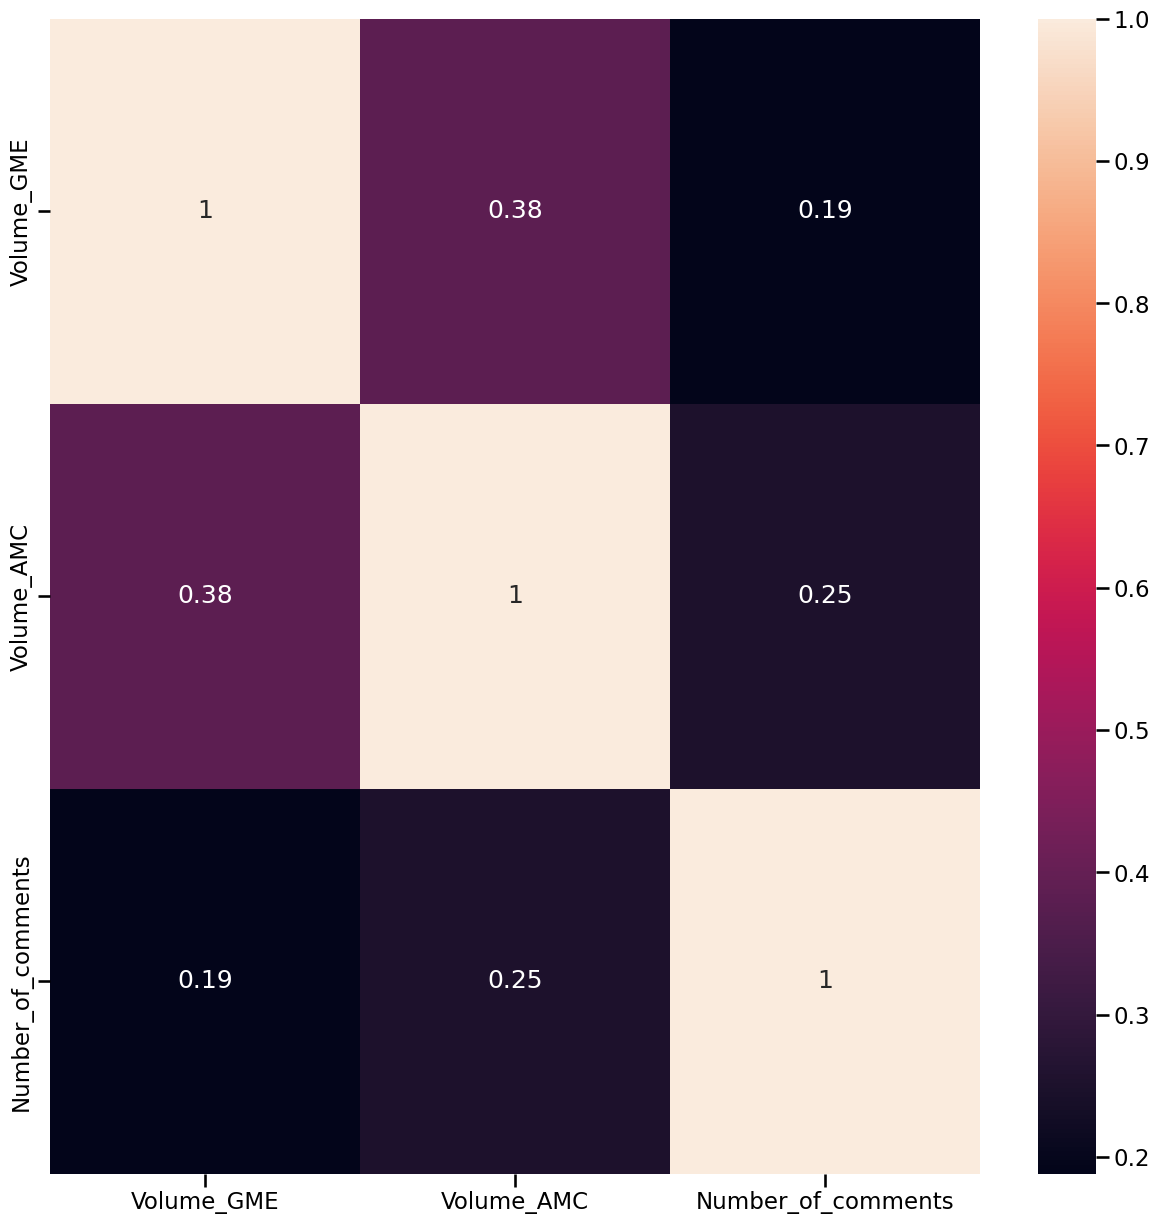

In [127]:
x = x.rename(columns={'Volume_x': 'Volume_GME',
                      'Volume_y': 'Volume_AMC',
                      'comms_num':'Number_of_comments'})

plt.figure(figsize=(15, 15))
sns.heatmap(x[['Volume_GME', 'Volume_AMC', 'Number_of_comments']].corr(), annot = True)
plt.savefig('my_plot7.png', transparent=True)
plt.show()

In [128]:
merged_data = merged_data.rename(columns={'close_returns_x': 'Returns_GME',
                      'close_returns_y': 'Returns_AMC',
                      'sent_score_x':'Sentiment_score_posts', 'sent_score_y':'Sentiment_score_comm'})

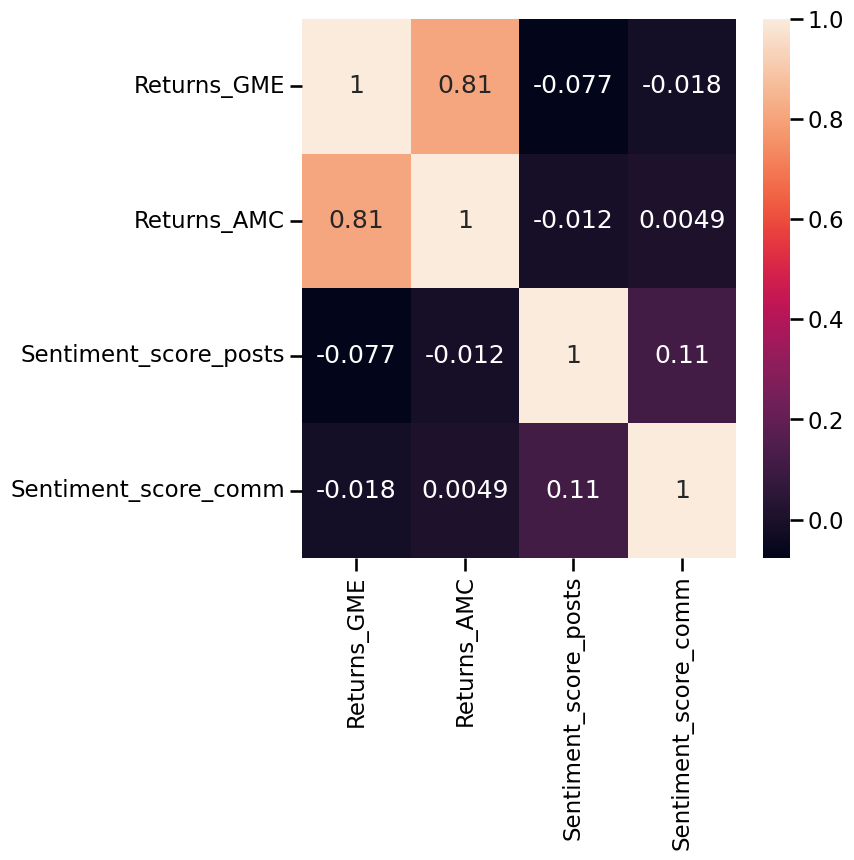

In [129]:
plt.figure(figsize=(7, 7))
sns.heatmap(merged_data[['Returns_GME', 'Returns_AMC', 'Sentiment_score_posts', 'Sentiment_score_comm']].drop_duplicates().corr(), annot = True)
plt.savefig('my_plot7.png', transparent=True)
plt.show()